In [40]:
from scipy.linalg import eigh
import numpy as np
from scipy.integrate import quad

def entropy_for_subsystem_n_cells(n, mod_v, mod_w, alpha):

    I_real = [0 for l in np.arange(-n+1,n)]
    I_imag = [0 for l in np.arange(-n+1,n)]
    #I_modulus = [0 for l in np.arange(0,n)]

    def denominator(k, mod_v, mod_w, alpha):
        return np.sqrt(mod_v**2 + mod_w**2 + 2 * mod_w * mod_v * np.cos(k - 2 * alpha))

    def real_integrand(k, l, mod_v, mod_w, alpha):
        numerator = mod_v * np.cos(alpha + k * l) + mod_w * np.cos(k * l + k - alpha)
        return (-1 / (4 * np.pi)) * numerator / denominator(k, mod_v, mod_w, alpha)

    def imag_integrand(k, l, mod_v, mod_w, alpha):
        numerator = mod_v * np.sin(alpha + k * l) + mod_w * np.sin(k * l + k - alpha)
        return (-1 / (4 * np.pi)) * numerator / denominator(k, mod_v, mod_w, alpha)

    # Compute integrals for all l values 
    def compute_integrals(n, mod_v, mod_w, alpha):
        l_values = np.arange(-n + 1, n)
        I_real = [quad(real_integrand, -np.pi, np.pi, args=(l, mod_v, mod_w, alpha), \
                       limit=150)[0] for l in l_values]
        I_imag = [quad(imag_integrand, -np.pi, np.pi, args=(l, mod_v, mod_w, alpha), \
                       limit=150)[0] for l in l_values]
        return I_real, I_imag

    I_real = compute_integrals(n, mod_v, mod_w, alpha)[0]
    I_imag = compute_integrals(n, mod_v, mod_w, alpha)[1]
    I = [real + 1j * imag for real, imag in zip(I_real, I_imag)]
    
    size = 2 * n
    correlation_matrix = np.zeros((size, size), dtype=complex)

    # Generate indices for I[l]
    l_values = np.arange(-n + 1, n)  # e.g., [-2, -1, 0, 1, 2] for n=3

    # Fill even rows (0, 2, 4, ...)
    for i in range(0, size, 2):
        for j in range(1, size, 2):
            l = (j - 1) // 2 - i // 2
            if l in l_values:
                correlation_matrix[i, j] = I[l + n - 1]

    # Fill odd rows (1, 3, 5, ...)
    for i in range(1, size, 2):
        for j in range(0, size, 2):
            l = (i - 1) // 2 - j // 2
            if l in l_values:
                correlation_matrix[i, j] = np.conj(I[l + n - 1])
    correlation_matrix = correlation_matrix + 0.5*np.eye(size)

    # computing eigenvalues of the correlation matrix and filter them  
    eigenvalues = eigh(correlation_matrix)[0]
    filtered_eigenvalues = eigenvalues[
    (np.abs(eigenvalues - 1) > 1e-10) & 
    (np.abs(eigenvalues) > 1e-10)]

    #computing entropy of the sub-system made by the N cells
    S = 0
    for zeta in filtered_eigenvalues:
        S += -(1 - zeta) * np.log(1 - zeta) - zeta * np.log(zeta)
    
    return S


entropy_for_subsystem_n_cells(11, 4, 0.01, 1)


np.float64(2.4618059357818367e-05)

Text(0.5, 1.0, 'entropy of sub-system A as a function of the number of scells')

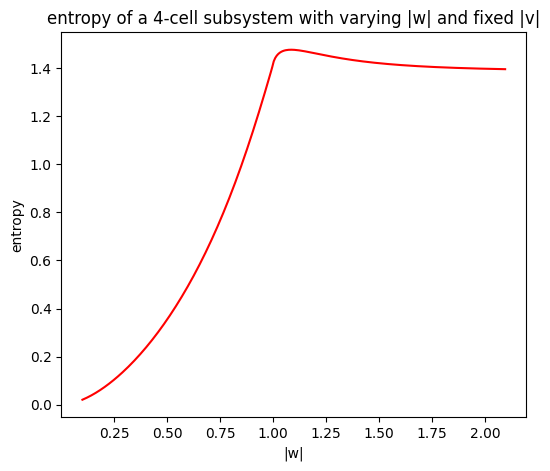

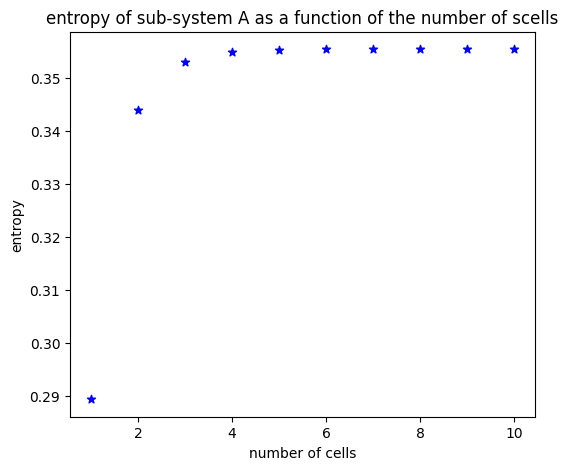

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['text.usetex'] = False

mod_w = np.arange(0.1, 2.1, 0.007)
entropies = [entropy_for_subsystem_n_cells(4, 1, i, 1) for i in mod_w]
fig1 = plt.figure(figsize=(6,5))
spec1 = gridspec.GridSpec(ncols=1, nrows=1)
ax1 = fig1.add_subplot(spec1[0,0])
ax1.plot(mod_w, entropies, color = 'red')
ax1.set_xlabel("|w|")
ax1.set_ylabel("entropy")
ax1.set_title("entropy of a 4-cell subsystem with varying |w| and fixed |v|")

number_of_cells = np.arange(1, 11, 1)
entropies = [entropy_for_subsystem_n_cells(i, 1, 0.5, 1) for i in number_of_cells]
fig2 = plt.figure(figsize=(6,5))
spec2 = gridspec.GridSpec(ncols=1, nrows=1)
ax2 = fig2.add_subplot(spec1[0,0])
ax2.scatter(number_of_cells, entropies, color = 'blue', marker = '*')
ax2.set_xlabel("number of cells")
ax2.set_ylabel("entropy")
ax2.set_title("entropy of sub-system A as a function of the number of cells")